In [1]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# グラフを描画するライブラリ
from matplotlib import pylab as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set()

# グラフの日本語表記
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

In [3]:
# データの読み込み
train_sample = pd.read_csv(
    "7-1-1-train-sample-1.csv", index_col="date", parse_dates=True, dtype="float"
)

# 日データであることの指定
train_sample.index.freq = "D"

# 結果の確認
print(train_sample.head(2))
print(train_sample.tail(2))

                     y
date                  
2000-05-01  182.079325
2000-05-02  141.334794
                     y
date                  
2000-08-07  264.246774
2000-08-08  214.887515


In [4]:
# ==============================================================
# 季節変動ありのローカル線形トレンドモデル（Local Linear Trend Model with Seasonality）
# ==============================================================

# UnobservedComponents（観測されない成分モデル）は、
# 状態空間モデル（State Space Model）をベースに、
# トレンド成分・季節成分・外生変数・誤差構造などを統合的に扱うクラスである。
#
# ここでは「ローカル線形トレンド」＋「季節変動（周期7）」をモデル化している。
# --------------------------------------------------------------

mod_sample = tsa.UnobservedComponents(
    endog=train_sample["y"],  # 対象の時系列データ
    level="local linear trend",  # 時間とともに変化する水準＋トレンド
    seasonal=7,  # 季節周期（7日周期の週次変動）
).fit()  # パラメータを最尤法（MLE）で推定

# ==============================================================
# 推定されたパラメータの確認
# ==============================================================

# .params で推定された分散パラメータなどを確認できる。
# 一般に、ローカル線形トレンドモデルでは以下が推定される：
#   - σ²_ε : 観測誤差（Irregular component）の分散
#   - σ²_η : 水準（Level component）の変動分散
#   - σ²_ζ : トレンド（Slope component）の変動分散
#   - （必要に応じて）季節成分の分散
#
# モデル構造の背後にある数式は次のように表される：
#
# 【状態空間表現】
# 観測方程式（Observation equation）:
#     y_t = μ_t + γ_t + ε_t,     ε_t ~ N(0, σ²_ε)
#
# 状態方程式（State equations）:
#     μ_t = μ_{t-1} + β_{t-1} + η_t,   η_t ~ N(0, σ²_η)
#     β_t = β_{t-1} + ζ_t,            ζ_t ~ N(0, σ²_ζ)
#     γ_t = -Σ_{i=1}^{s-1} γ_{t-i} + ω_t, ω_t ~ N(0, σ²_γ)   （季節性成分）
#
# ここで：
#   μ_t : 水準（Level）
#   β_t : トレンド（Slope）
#   γ_t : 季節性（Seasonal）
#   ε_t : 観測誤差
# --------------------------------------------------------------

print(mod_sample.params)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34797D+00    |proj g|=  1.06009D-02

At iterate    5    f=  3.06172D+00    |proj g|=  7.34555D-02

At iterate   10    f=  2.96718D+00    |proj g|=  8.73561D-03

At iterate   15    f=  2.93725D+00    |proj g|=  3.43616D-02

At iterate   20    f=  2.90440D+00    |proj g|=  1.72459D-02

At iterate   25    f=  2.90263D+00    |proj g|=  5.42255D-04

At iterate   30    f=  2.90262D+00    |proj g|=  2.36588D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


In [5]:
# 予測
forecast_sample = mod_sample.forecast(7)

# 予測結果の確認
forecast_sample

2000-08-09    246.808962
2000-08-10    277.554573
2000-08-11    296.189758
2000-08-12    325.585518
2000-08-13    317.301612
2000-08-14    269.799431
2000-08-15    221.201080
Freq: D, Name: predicted_mean, dtype: float64

In [6]:
# モデルの保存
# 事前にmodフォルダを作っておくこと
mod_sample.save("./mod/bsts_sample.pickle")

In [7]:
# モデルの読み込み
mod_loaded = tsa.statespace.MLEResults.load("./mod/bsts_sample.pickle")

# パラメータが一致していることの確認
mod_loaded.params == mod_sample.params

sigma2.irregular    True
sigma2.level        True
sigma2.trend        True
sigma2.seasonal     True
dtype: bool

In [8]:
# パラメータの出力
mod_sample.params.to_csv("./mod/params_sample.csv", header=False)

In [9]:
# パラメータの読み込み
imported_params = (
    pd.read_csv("./mod/params_sample.csv", header=None, index_col=0, dtype=object)
    .squeeze(1)
    .astype("float64")
)

# パラメータが一致していることの確認
imported_params == mod_sample.params

0
sigma2.irregular    True
sigma2.level        True
sigma2.trend        True
sigma2.seasonal     True
dtype: bool

In [10]:
# ==============================================================
# 既存パラメータを使ったローカル線形トレンドモデルの再フィルタリング
# ==============================================================

# UnobservedComponents は、状態空間モデル（State Space Model）を構築し、
# トレンド・季節・ノイズ構造を同時に扱うことができるクラスである。
# 今回は、既に推定済みのパラメータ（imported_params）を用いて、
# 別インスタンスのモデルに「再利用」する処理を行う。
# --------------------------------------------------------------

# 1. モデル構造の定義
mod_sample_useparams = tsa.UnobservedComponents(
    endog=train_sample["y"],  # 対象の時系列データ
    level="local linear trend",  # 時間的に滑らかに変化する水準＋トレンド
    seasonal=7,  # 7時点周期（週次の季節成分）
)

# 2. 既に別モデルで推定したパラメータを用いてフィルタリングを実施
# --------------------------------------------------------------
# .filter(params=...) により、最尤推定を再度行わずに、
# 指定したパラメータ値でカルマンフィルタを適用する。
#
# imported_params は、以前に fit() により推定された分散パラメータ群であり、
# 以下のような要素を含むことが多い：
#   - σ²_ε : 観測誤差（Irregular component）の分散
#   - σ²_η : 水準成分（Level component）の分散
#   - σ²_ζ : トレンド成分（Slope component）の分散
#   - σ²_γ : 季節成分（Seasonal component）の分散
# --------------------------------------------------------------

mod_sample_useparams = mod_sample_useparams.filter(
    params=imported_params  # 他モデルから引き継いだパラメータ
)

# 3. 理論的背景（カルマンフィルタ再適用）
# --------------------------------------------------------------
# UnobservedComponents.filter() は以下の処理を行う：
#
# (1) 予測ステップ（Prediction Step）
#     状態方程式：
#         α_{t|t-1} = T * α_{t-1|t-1}
#         P_{t|t-1} = T * P_{t-1|t-1} * T' + Q
#
# (2) 更新ステップ（Update Step）
#     観測方程式：
#         v_t = y_t - Z * α_{t|t-1}
#         F_t = Z * P_{t|t-1} * Z' + H
#         K_t = P_{t|t-1} * Z' * F_t^{-1}
#         α_{t|t} = α_{t|t-1} + K_t * v_t
#         P_{t|t} = P_{t|t-1} - K_t * F_t * K_t'
#
# この計算により、各時点でのフィルタ化推定量（a_t, P_t）が再帰的に得られる。
# --------------------------------------------------------------

# 4. 予測の一致確認
# --------------------------------------------------------------
# imported_params に基づく再フィルタリング後のモデルで、
# forecast(7)（7時点先予測）を実行し、
# 以前の結果 forecast_sample と完全一致することを確認する。
#
# これは、同一のモデル構造と同一パラメータを用いた場合、
# フィルタリングと予測の結果が理論的に再現可能であることを示す。

all(mod_sample_useparams.forecast(7) == forecast_sample)

True

In [11]:
# データの読み込み
train_sample_2 = pd.read_csv(
    "7-1-2-train-sample-2.csv", index_col="date", parse_dates=True, dtype="float"
)

# 日データであることの指定
train_sample_2.index.freq = "D"

# 結果の確認
print(train_sample_2.head(2))
print(train_sample_2.tail(2))

                     y
date                  
2000-05-01  182.079325
2000-05-02  141.334794
                     y
date                  
2000-08-14  294.948285
2000-08-15  243.335236


In [12]:
# パラメータを設定
mod_newdata = tsa.UnobservedComponents(
    train_sample_2["y"],  # 対象データ(新しいデータに変更)
    level="local linear trend",  # ローカル線形トレンド
    seasonal=7,  # 周期
)

# パラメータを指定してフィルタリング
mod_newdata = mod_newdata.filter(params=imported_params)

# パラメータが一致していることの確認
mod_newdata.params == mod_sample.params

sigma2.irregular    True
sigma2.level        True
sigma2.trend        True
sigma2.seasonal     True
dtype: bool

In [13]:
# フィルター化推定量の比較
all(mod_newdata.level["filtered"][0:100] == mod_sample.level["filtered"])

True

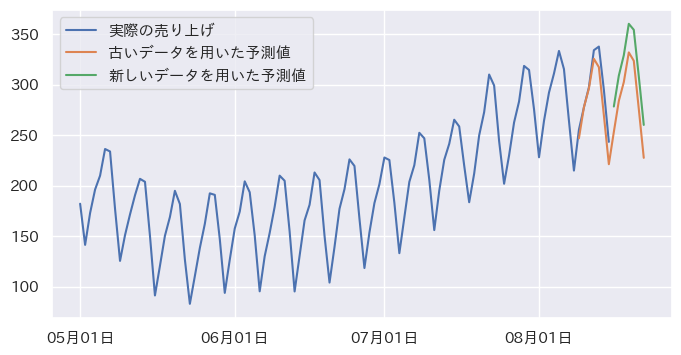

In [14]:
# 古いデータを使ったモデルで2週間先まで予測
old_forecast = mod_sample.forecast(14)

# 新しいデータを使ったモデルで1週間先まで予測
new_forecast = mod_newdata.forecast(7)

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 折れ線グラフを描く
ax.plot(train_sample_2, label="実際の売り上げ")
ax.plot(old_forecast, label="古いデータを用いた予測値")
ax.plot(new_forecast, label="新しいデータを用いた予測値")

# 凡例
ax.legend()

# 軸の指定
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# 軸ラベルのフォーマット
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m月%d日"))

# plt.savefig('../図/図/7-1-1-データを追加することで変化する予測結果.svg')